**Parametric VaR Estimation: Cornish-Fisher & Student-T**

This notebook builds on the synthetic return data to estimate Value-at-Risk (VaR) using both empirical and parametric approaches. It computes historical quantile VaR, Cornish-Fisher adjusted VaR to account for skewness and kurtosis, and Student-t VaR to capture heavy-tailed behavior, across multiple confidence levels. The notebook includes visual comparisons of VaR profiles for each asset, highlighting how different statistical assumptions impact tail-risk estimates, and demonstrates a workflow for quantifying downside risk in financial returns.


Parametric & Empirical VaR Comparison:



,Asset,Empirical VaR 1%,Cornish-Fisher VaR 1%,Student-t VaR 1%,Empirical VaR 5%,Cornish-Fisher VaR 5%,Student-t VaR 5%,Empirical VaR 10%,Cornish-Fisher VaR 10%,Student-t VaR 10%
0,Asset_A,0.030735,0.033363,0.038107,0.022389,0.023358,0.021341,0.018171,0.018024,0.015126
1,Asset_B,0.048300,0.044769,0.051212,0.031333,0.031180,0.028440,0.023673,0.023936,0.020000
2,Asset_C,0.064601,0.056843,0.064693,0.039479,0.040290,0.036953,0.028860,0.031466,0.026671


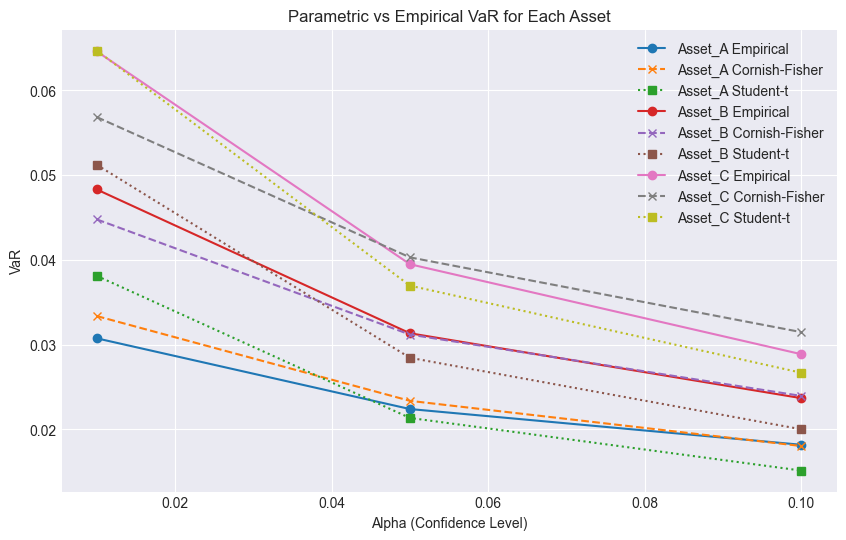

In [1]:
# Extreme Risk Estimation
# Compute parametric VaR using Cornish-Fisher and Student-t methods

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, t, moment

plt.style.use("seaborn-v0_8-darkgrid")

# Load Simulated Returns
returns_df = pd.read_csv("data/simulated_returns.csv")
returns_df.head()


# Define Helper Functions
def cornish_fisher(alpha, data):
    """Compute Cornish-Fisher VaR at confidence level alpha."""
    mu = np.mean(data)
    sigma = np.std(data)
    N_ = norm.ppf(alpha)
    K3 = moment(data, moment=3)
    K4 = moment(data, moment=4) - 3 * (moment(data, moment=2) ** 2)

    CF_VaR = - mu - sigma * (
        N_
        + ((N_**2 - 1)/6 * K3)
        + ((N_**3 - 3*N_)/24 * K4)
        - ((2*N_**3 - 5*N_)/36 * K3**2)
    )
    return CF_VaR

def student_t_var(alpha, data):
    """Compute Student-t VaR at confidence level alpha using method-of-moments."""
    mu = np.mean(data)
    sigma = np.std(data)
    df = 4  # degrees of freedom for heavy tails
    T_ = t.ppf(alpha, df)
    ST_VaR = - (T_ * sigma * np.sqrt((df-2)/df)) - mu
    return ST_VaR

def empirical_var(data, alpha=0.05):
    """Compute empirical quantile VaR."""
    return -np.quantile(data, alpha)

# Set Confidence Levels
alphas = [0.01, 0.05, 0.1]  # 1%, 5%, 10%

# Compute VaR for Each Asset
results = []

for asset in returns_df.columns:
    data = returns_df[asset]
    row = {'Asset': asset}
    for alpha in alphas:
        row[f'Empirical VaR {int(alpha*100)}%'] = empirical_var(data, alpha)
        row[f'Cornish-Fisher VaR {int(alpha*100)}%'] = cornish_fisher(alpha, data)
        row[f'Student-t VaR {int(alpha*100)}%'] = student_t_var(alpha, data)
    results.append(row)

var_df = pd.DataFrame(results)
print("\nParametric & Empirical VaR Comparison:\n")
display(var_df)

# Plot VaR Profiles
fig, ax = plt.subplots(figsize=(10, 6))
for asset in returns_df.columns:
    empirical = [empirical_var(returns_df[asset], alpha) for alpha in alphas]
    cf = [cornish_fisher(alpha, returns_df[asset]) for alpha in alphas]
    st = [student_t_var(alpha, returns_df[asset]) for alpha in alphas]
    
    ax.plot(alphas, empirical, marker='o', label=f'{asset} Empirical')
    ax.plot(alphas, cf, marker='x', linestyle='--', label=f'{asset} Cornish-Fisher')
    ax.plot(alphas, st, marker='s', linestyle=':', label=f'{asset} Student-t')

ax.set_xlabel("Alpha (Confidence Level)")
ax.set_ylabel("VaR")
ax.set_title("Parametric vs Empirical VaR for Each Asset")
ax.legend()
plt.show()
